In [1]:
%matplotlib inline

### Install Python Packages

In [2]:
# include our Python packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd import Function
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from tqdm import tqdm

### Get MNIST Dataset and DataLoader

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Flatten operation (assuming you want to flatten the tensor along the spatial dimensions)
flatten = transforms.Lambda(lambda x: x.view(-1))

# Combine the original transforms with the flatten operation
combined_transform = transforms.Compose([
    transform,
    flatten,
])

train_dataset = MNIST(root='./data', train=True, transform=combined_transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)

test_dataset = MNIST(root='./data', train=False, download=True, transform=combined_transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=50, shuffle=True)

#### View Images

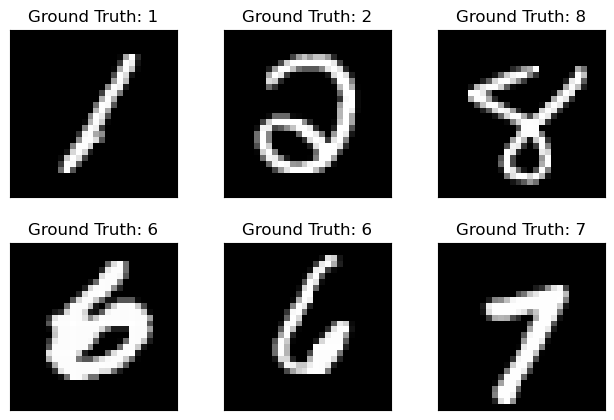

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

### Create MLP

In [5]:
class MLP(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(D_in, H1),
            nn.ReLU(),
            nn.Linear(H1, H2),
            nn.ReLU(),
            nn.Linear(H2, D_out),
        )
    def forward(self, x):
        y_pred = self.layers(x)
        return y_pred

### Create Convolutional Nerual Net

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

### Select Model and Define HyperParameters

In [15]:
model = MLP(
    D_in = 28*28,
    H1 = 28*28,
    H2 = 128,
    D_out = 10,
)
# model = CNN()

print(model)

epochs = 10
learning_rate = 0.001
momentum = 0.3

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

criterion = nn.CrossEntropyLoss()

status_interval = 10

MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=784, bias=True)
    (1): ReLU()
    (2): Linear(in_features=784, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


### Define Training Function

In [19]:
train_loss = []
train_count = []
test_loss = []
test_count = [i*len(train_loader.dataset) for i in range(epochs + 1)]

def train(epoch, dataloader, optimizer):
    model.train()

    print(f'Train Epoch: {epoch}')

    for batch, (data, label) in tqdm(enumerate(dataloader)):
        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, label)
        # loss = F.nll_loss(output, label)
        loss.backward()

        optimizer.step()

        if batch % status_interval == 0:
            # print(f'Train Epoch: {epoch} [{batch * len(data)}/{len(dataloader.dataset)}] ({batch * 100 / len(dataloader):.0f}%)\tLoss: {loss.item():.6f}')
            train_loss.append(loss.item())
            train_count.append((batch*64) + ((epoch-1)*len(dataloader.dataset)))

    print(f'Loss: {loss.item():.6f}')

### Define Training Function

In [22]:
def test(dataloader):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, label in dataloader:
            output = model(data)
            loss += F.nll_loss(output, label, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(label.data.view_as(pred)).sum()
    loss /= len(dataloader.dataset)
    test_loss.append(loss)
    print(f'\nTest Set: Avg. Loss: {loss:.4f}, Accuracy: {correct}/{len(dataloader.dataset)} ({100 * correct / len(dataloader.dataset):.0f}%)')

### Train Model

In [23]:
# test(dataloader=test_loader)
for epoch in range(0, epochs):
     print('==='*30)
     train(epoch=epoch+1, dataloader=train_loader, optimizer=optimizer)
     test(dataloader=test_loader)

Train Epoch: 1


0it [00:00, ?it/s]C:\Users\rdash\AppData\Local\Temp\ipykernel_39496\3801493435.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
1200it [00:08, 142.52it/s]


Loss: 0.401372

Test Set: Avg. Loss: 0.1687, Accuracy: 9464/10000 (95%)
Train Epoch: 2


1200it [00:08, 133.39it/s]


Loss: 0.376274

Test Set: Avg. Loss: 0.1632, Accuracy: 9504/10000 (95%)
Train Epoch: 3


1200it [00:08, 141.08it/s]


Loss: 0.239260

Test Set: Avg. Loss: 0.1547, Accuracy: 9510/10000 (95%)
Train Epoch: 4


1200it [00:08, 144.34it/s]


Loss: 0.359518

Test Set: Avg. Loss: 0.1507, Accuracy: 9541/10000 (95%)
Train Epoch: 5


1200it [00:08, 144.21it/s]


Loss: 0.502613

Test Set: Avg. Loss: 0.1442, Accuracy: 9551/10000 (96%)
Train Epoch: 6


1200it [00:08, 139.78it/s]


Loss: 0.806576

Test Set: Avg. Loss: 0.1396, Accuracy: 9564/10000 (96%)
Train Epoch: 7


1200it [00:08, 137.32it/s]


Loss: 0.261044

Test Set: Avg. Loss: 0.1363, Accuracy: 9567/10000 (96%)
Train Epoch: 8


1200it [00:08, 139.65it/s]


Loss: 0.266346

Test Set: Avg. Loss: 0.1315, Accuracy: 9590/10000 (96%)
Train Epoch: 9


1200it [00:08, 137.71it/s]


Loss: 0.419375

Test Set: Avg. Loss: 0.1285, Accuracy: 9601/10000 (96%)
Train Epoch: 10


1200it [00:08, 143.61it/s]


Loss: 0.352322

Test Set: Avg. Loss: 0.1245, Accuracy: 9604/10000 (96%)


### Test Model

In [24]:
test(test_loader)

C:\Users\rdash\AppData\Local\Temp\ipykernel_39496\3801493435.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test Set: Avg. Loss: 0.1245, Accuracy: 9604/10000 (96%)


### Plot Results

ValueError: x and y must be the same size

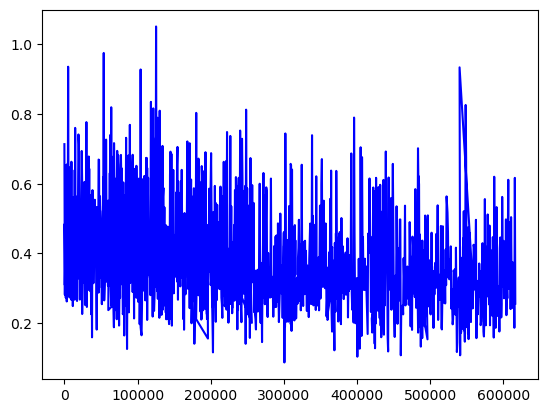

In [25]:
fig = plt.figure()
plt.plot(train_count, train_loss, color='blue')
plt.scatter(test_count, test_loss, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

C:\Users\rdash\AppData\Local\Temp\ipykernel_39496\3801493435.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


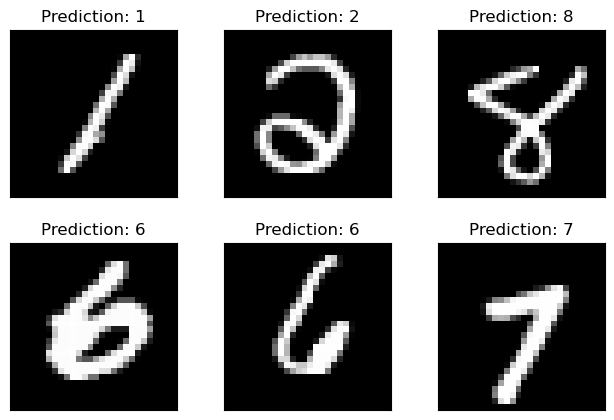

In [27]:
with torch.no_grad():
  output = model(example_data)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])